In [1]:
import torch.nn as nn
import torch as T
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from random import randint, random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from src.pecan_dataport.participant_preprocessing import PecanParticipantPreProcessing

<center>Simulated annealing loss function</center>
$$ Energy Ensemble_{loss} = \frac{\sum_{i=0}^{i}(w_i*s_i)}{n_{ensemblemodels}} $$

In [2]:
class SimulatedAnnealing:
    def __init__(self, label, models_prediction, x0, opt_mode, cooling_schedule='linear',
                 step_max=1000, t_min=0, t_max=100, bounds=[], alpha=None, damping=1):
        assert opt_mode in ['combinatorial', 'continuous', 'base'], 'opt_mode must be either "combinatorial" or "continuous"'
        assert cooling_schedule in ['linear', 'exponential', 'logarithmic', 'quadratic'], 'cooling_schedule must be either in ["linear", "exponential", "logarithmic", "quadratic"]'

        self.label = label
        self.predictions = models_prediction
        self.t = t_max
        self.t_max = t_max
        self.t_min = t_min
        self.step_max = step_max
        self.opt_mode = opt_mode
        self.hist = []
        self.cooling_schedule = cooling_schedule

        self.cost_func = self.EnsembleMSEFunc
        self.x0 = x0
        self.bounds = bounds[:]
        self.damping = damping
        self.current_state = self.x0
        self.current_energy = self.EnsembleMSEFunc(self.x0, label, models_prediction)
        self.best_state = self.current_state
        self.best_energy = self.current_energy

        if self.opt_mode == 'combinatorial': self.get_neighbor = self.move_combinatorial
        if self.opt_mode == 'continuous': self.get_neighbor = self.move_continuous
        if self.opt_mode == 'base': self.get_neighbor = self.base_solution

        if self.cooling_schedule == 'linear':
            if alpha != None:
                self.update_t = self.cooling_linear_m
                self.cooling_schedule = 'linear multiplicative cooling'
                self.alpha = alpha
            if alpha == None:
                self.update_t = self.cooling_linear_a
                self.cooling_schedule = 'linear additive cooling'

        if self.cooling_schedule == 'quadratic':
            if alpha != None:
                self.update_t = self.cooling_quadratic_m
                self.cooling_schedule = 'quadratic multiplicative cooling'
                self.alpha = alpha
            if alpha == None:
                self.update_t = self.cooling_quadratic_a
                self.cooling_schedule = 'quadratic additive cooling'

        if self.cooling_schedule == 'exponential':
            if alpha == None:
                self.alpha = 0.8
            else:
                self.alpha = alpha
            self.update_t = self.cooling_exponential

        if self.cooling_schedule == 'logarithmic':
            if alpha == None:
                self.alpha = 0.8
            else:
                self.alpha = alpha
            self.update_t = self.cooling_logarithmic

        self.step, self.accept = 1, 0
        while self.step < self.step_max and self.t >= self.t_min and self.t > 0:
            proposed_neighbor = self.get_neighbor()

            E_n = self.cost_func(proposed_neighbor, self.label, self.predictions)
            dE = E_n - self.current_energy

            if random() < self.safe_exp(-dE / self.t):
                self.current_energy = E_n
                self.current_state = proposed_neighbor[:]
                self.accept += 1

            if E_n < self.best_energy:
                self.best_energy = E_n
                self.best_state = proposed_neighbor[:]
                self.best_ensemble_result = self.weight_avg

            self.hist.append([self.step, self.t, self.current_energy, self.best_energy])

            self.t = self.update_t(self.step)
            self.step += 1

        self.acceptance_rate = self.accept / self.step

    def base_solution(self):
        neighbor = self.current_state.copy()
        p1, p2 = np.random.randint(0, len(self.current_state)), np.random.randint(0, len(self.current_state))
        v = np.random.uniform(0, self.current_state[p2])

        neighbor[p1] = min(1, self.current_state[p1] + v)
        neighbor[p2] = max(0, self.current_state[p2] - v)
        return neighbor

    def move_continuous(self):
        neighbor = [item + ((np.random.uniform(0,1) - 0.5) * self.damping) for item in self.current_state]

        if self.bounds:
            for i in range(len(neighbor)):
                x_min, x_max = self.bounds[i]
                neighbor[i] = min(max(neighbor[i], x_min), x_max)
        return neighbor

    def move_combinatorial(self):
        p0 = randint(0, len(self.current_state) - 1)
        p1 = randint(0, len(self.current_state) - 1)

        neighbor = self.current_state[:]
        neighbor[p0], neighbor[p1] = neighbor[p1], neighbor[p0]

        return neighbor

    def cooling_linear_m(self, step):
        return self.t_max / (1+self.alpha * step)

    def cooling_linear_a(self, step):
        return self.t_min + (self.t_max - self.t_min) * ((self.step_max - step)/self.step_max)

    def cooling_quadratic_m(self, step):
        return self.t_min / (1 + self.alpha * step**2)

    def cooling_quadratic_a(self, step):
        return self.t_min + (self.t_max - self.t_min) * ((self.t_max - step) / self.step_max)**2

    def cooling_exponential_m(self, step):
        return self.t_max * self.alpha**step

    def cooling_logarithmic_m(self, step):
        return self.t_max / (self.alpha * math.log(step + 1))

    def safe_exp(self, x):
        try:
            return math.exp(x)
        except:
            return 0
    
    def EnsembleMSEFunc(self, weights, labels, models_predictions):
        weight_sum = []

        for prediction, weight in zip(models_predictions, weights):
            weight_sum.append(prediction * weight)

        self.weight_avg = np.sum(weight_sum, axis=0)/np.sum(weights, axis=0)

        return MSEError(labels, self.weight_avg)


In [3]:
def MSEError(labels, predictions):
    return np.sum(np.diff([labels, predictions], axis=0)**2)/len(predictions)

def RMSEError(labels, predictions):
    return (MSEError(labels, predictions))**0.5

def MAEError(labels, predictions):
    return np.sum(abs(np.diff([labels, predictions], axis=0)))/len(predictions)

def MAPEError(labels, predictions):
    return np.sum(abs(np.divide(np.diff([labels, predictions], axis=0), labels)))/len(predictions)

def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

def PolarPlotMaker(labels: list, values: list, polar_color:str, polar_legend: str):
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, color=polar_color, linewidth=1)
    # Fill it in.
    ax.fill(angles, values, color=polar_color, alpha=0.25)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles), labels)

    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')

    ax.set_rlabel_position(180 / num_vars)
    ax.set_title(polar_legend, y=1.08)
    plt.show()

In [4]:
pecan_dataset = PecanParticipantPreProcessing('661_test_30_pca', 'data/participants_data/1min/', 60)
default_scaler = pecan_dataset.get_scaler()

[!] - Trainable dataframe shape - (129086, 18)
[*] Train dataframe shape: (90360, 18)
[*] Validation dataframe shape: (25817, 18)
[*] Test dataframe shape: (12909, 18)


100%|█████████████████████████████████████████████████████████████████████████| 25757/25757 [00:01<00:00, 13116.32it/s]

[!] Train sequence shape: (60, 18)
[!] Val sequence shape: (60, 18)


In [5]:
with open(f'etc/results/661_test_30_pca/result_report.json') as json_file:
    data = json.load(json_file)
    json_file.close()

In [6]:
predictions_data = data 
new_prediction_data = []
new_result_data = []
for model in predictions_data:
    for prediction in model['predict']:
        prediction['model'] = model['model']
    for result in model['test']:
        result['model'] = model['model']
    new_result_data += model['test']
    new_prediction_data += model['predict']
complete_prediction_df = pd.DataFrame(new_prediction_data)
complete_result_df = pd.DataFrame(new_result_data)

In [7]:
complete_prediction_df

,label,model_output,loss,model
0,-0.531253,-0.564917,0.001133,LSTM
1,-0.529845,-0.563435,0.001128,LSTM
2,-0.527775,-0.561514,0.001138,LSTM
3,-0.526451,-0.558852,0.001050,LSTM
4,-0.525871,-0.557558,0.001004,LSTM
...,...,...,...,...
77089,-0.739217,-0.514530,0.050484,Transformer
77090,-0.735160,-0.514417,0.048728,Transformer
77091,-0.735243,-0.514284,0.048823,Transformer
77092,-0.741204,-0.513888,0.051673,Transformer


In [8]:
complete_result_df

,test/MAE,test/MAPE,test/SMAPE,test/WMAPE,test/MSE,test/RMSE,test/MSLE,test/test_loss,model
0,0.040248,0.207194,0.128130,0.207194,0.004104,0.040248,0.021818,0.004104,LSTM
1,0.026051,0.161302,0.100558,0.161302,0.002855,0.026051,0.017401,0.002855,RNN
2,0.029107,0.165222,0.103902,0.165222,0.003213,0.029107,0.018365,0.003213,GRU
3,0.042662,0.232067,0.165128,0.232067,0.005327,0.042662,0.037963,0.005327,TCN
4,0.050360,0.398465,0.182121,0.398465,0.007353,0.050360,0.059671,0.007353,TST
5,0.168392,0.840952,0.447263,0.840952,0.037450,0.168392,0.207003,0.037450,Transformer


In [9]:
calc_result = []
labels = np.array(complete_prediction_df[complete_prediction_df['model'] == 'GRU'].label)
for model in list(complete_result_df.model):
    predictions = np.array(complete_prediction_df[complete_prediction_df['model'] == model].model_output)
    calc_result.append({
        'calculate_MSE':MSEError(labels, predictions),
        'calculate_RMSE':RMSEError(labels, predictions),
        'calculate_MAE':MAEError(labels, predictions),
        'calculate_MAPE': MAPEError(labels, predictions),
        'r2': r2_score(labels, predictions),
        'model': model
    })
calc_result_df = pd.DataFrame(calc_result)
base_result = calc_result_df.copy()
calc_result_df

,calculate_MSE,calculate_RMSE,calculate_MAE,calculate_MAPE,r2,model
0,0.004104,0.064062,0.040248,0.207194,0.895259,LSTM
1,0.002855,0.053434,0.026051,0.161302,0.927130,RNN
2,0.003213,0.056681,0.029107,0.165222,0.918004,GRU
3,0.005327,0.072988,0.042662,0.232068,0.864038,TCN
4,0.007353,0.085752,0.050360,0.398466,0.812328,TST
5,0.037450,0.193519,0.168392,0.840950,0.044209,Transformer


# Ensemble of Recorrent Nets

In [10]:
labels = np.array(complete_prediction_df[complete_prediction_df['model'] == 'GRU'].label)

In [11]:
gru_outputs = np.array(complete_prediction_df[complete_prediction_df['model'] == 'GRU'].model_output)
lstm_outputs = np.array(complete_prediction_df[complete_prediction_df['model'] == 'LSTM'].model_output)
rnn_outputs = np.array(complete_prediction_df[complete_prediction_df['model'] == 'RNN'].model_output)

## Fusion Ensemble

In [12]:
ensemble_predictions = np.sum([gru_outputs, lstm_outputs, rnn_outputs], axis=0)/3
avg_ensemble_df = pd.DataFrame({'label': labels, 'model_output': ensemble_predictions, 'model':'RecorrentAvgEnsemble'})
complete_prediction_df = pd.concat([complete_prediction_df, avg_ensemble_df])

In [13]:
calc_result_df = pd.concat([calc_result_df, pd.DataFrame([{ 
    'calculate_MSE': MSEError(labels, ensemble_predictions),
    'calculate_RMSE': RMSEError(labels, ensemble_predictions),
    'calculate_MAE': MAEError(labels, ensemble_predictions),
    'calculate_MAPE': MAPEError(labels, ensemble_predictions),
    'r2': r2_score(labels, ensemble_predictions),
    'model': 'RecorrentAvgEnsemble'
}])])

calc_result_df

,calculate_MSE,calculate_RMSE,calculate_MAE,calculate_MAPE,r2,model
0,0.004104,0.064062,0.040248,0.207194,0.895259,LSTM
1,0.002855,0.053434,0.026051,0.161302,0.927130,RNN
2,0.003213,0.056681,0.029107,0.165222,0.918004,GRU
3,0.005327,0.072988,0.042662,0.232068,0.864038,TCN
4,0.007353,0.085752,0.050360,0.398466,0.812328,TST
5,0.037450,0.193519,0.168392,0.840950,0.044209,Transformer
0,0.003042,0.055153,0.029939,0.168928,0.922367,RecorrentAvgEnsemble


## Weight Ensemble by Grid Search

In [14]:
weights = np.arange(0.01, 1.01, .05)
weights_ensemble = []
weights

array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96])

In [15]:
for w1 in weights:
    for w2 in weights:
        for w3 in weights:
            ensemble_wavg_predictions = np.sum([gru_outputs * w1, lstm_outputs * w2, rnn_outputs * w3], axis=0)/(w1+w2+w3)
            data = {
                'w1': w1,
                'w2': w2,
                'w3': w3,
                'wavg_ensemble': ensemble_wavg_predictions,
                'calculate_MSE': MSEError(labels, ensemble_wavg_predictions),
                'calculate_RMSE': RMSEError(labels, ensemble_wavg_predictions),
                'calculate_MAE': MAEError(labels, ensemble_wavg_predictions),
                'calculate_MAPE': MAPEError(labels, ensemble_wavg_predictions),
                'r2': r2_score(labels, ensemble_wavg_predictions),
            }
            weights_ensemble.append(data)

In [16]:
w_avg = pd.DataFrame(weights_ensemble)
w_avg['calculate_MSE'].idxmin()

2018

In [17]:
w_avg[w_avg.index == w_avg['calculate_MSE'].idxmin()]

,w1,w2,w3,wavg_ensemble,calculate_MSE,calculate_RMSE,calculate_MAE,calculate_MAPE,r2
2018,0.26,0.01,0.91,"[-0.5357856477721262, -0.5357026427479112, -0....",0.002823,0.053131,0.026273,0.159467,0.927953


In [18]:
best_enseble = w_avg.iloc[w_avg['calculate_MSE'].idxmin(),:]
w_avg_prediction = best_enseble['wavg_ensemble']
w_avg_ensemble_df = pd.DataFrame({'label': labels, 'model_output': w_avg_prediction, 'model':'GSWeightedRecorrentAvgEnsemble'})
complete_prediction_df = pd.concat([complete_prediction_df, w_avg_ensemble_df])

In [19]:
calc_result_df = pd.concat([calc_result_df, pd.DataFrame([{ 
    'calculate_MSE': best_enseble['calculate_MSE'],
    'calculate_RMSE': best_enseble['calculate_RMSE'],
    'calculate_MAE': best_enseble['calculate_MAE'],
    'calculate_MAPE': best_enseble['calculate_MAPE'],
    'r2': best_enseble['r2'],
    'model': 'GS-WAvgRecorrentAvgEnsemble'
}])])
calc_result_df

,calculate_MSE,calculate_RMSE,calculate_MAE,calculate_MAPE,r2,model
0,0.004104,0.064062,0.040248,0.207194,0.895259,LSTM
1,0.002855,0.053434,0.026051,0.161302,0.927130,RNN
2,0.003213,0.056681,0.029107,0.165222,0.918004,GRU
3,0.005327,0.072988,0.042662,0.232068,0.864038,TCN
4,0.007353,0.085752,0.050360,0.398466,0.812328,TST
5,0.037450,0.193519,0.168392,0.840950,0.044209,Transformer
0,0.003042,0.055153,0.029939,0.168928,0.922367,RecorrentAvgEnsemble
0,0.002823,0.053131,0.026273,0.159467,0.927953,GS-WAvgRecorrentAvgEnsemble


## Weigth Avg by Simulated Annealing - continous mode

In [20]:
rnn_models = ['LSTM', 'RNN', 'GRU']
rnn_weights = [1, 1, 1]
recorrent_predictions = []
for model in rnn_models:
    recorrent_predictions.append(np.array(complete_prediction_df[complete_prediction_df['model'] == model].model_output))
recorrent_predictions = np.array(recorrent_predictions)

In [21]:
sa = SimulatedAnnealing(label=labels, models_prediction=recorrent_predictions, x0=rnn_weights, opt_mode='continuous', step_max=100000, t_max=10000)
print(f"[!] - Best MSE found - {sa.best_energy}")
print(f"[!] - Best weights found - {sa.best_state}")


[!] - Best MSE found - 0.002899411842358918
[!] - Best weights found - [0.5031565630645075, 1.4989379555449078, 0.8069019380664857]


In [22]:
calc_result_df = pd.concat([calc_result_df, pd.DataFrame([{ 
    'calculate_MSE': MSEError(labels, sa.best_ensemble_result),
    'calculate_RMSE': RMSEError(labels, sa.best_ensemble_result),
    'calculate_MAE': MAEError(labels, sa.best_ensemble_result),
    'calculate_MAPE': MAPEError(labels, sa.best_ensemble_result),
    'r2': r2_score(labels, sa.best_ensemble_result),
    'model': 'SA-AvgRecorrentAvgEnsemble'
}])])

calc_result_df

,calculate_MSE,calculate_RMSE,calculate_MAE,calculate_MAPE,r2,model
0,0.004104,0.064062,0.040248,0.207194,0.895259,LSTM
1,0.002855,0.053434,0.026051,0.161302,0.927130,RNN
2,0.003213,0.056681,0.029107,0.165222,0.918004,GRU
3,0.005327,0.072988,0.042662,0.232068,0.864038,TCN
4,0.007353,0.085752,0.050360,0.398466,0.812328,TST
5,0.037450,0.193519,0.168392,0.840950,0.044209,Transformer
0,0.003042,0.055153,0.029939,0.168928,0.922367,RecorrentAvgEnsemble
0,0.002823,0.053131,0.026273,0.159467,0.927953,GS-WAvgRecorrentAvgEnsemble
0,0.002899,0.053846,0.027952,0.163533,0.926001,SA-AvgRecorrentAvgEnsemble


['LSTM', 'RNN', 'GRU', 'TCN', 'TST', 'Transformer', 'RecorrentAvgEnsemble', 'GS-WAvgRecorrentAvgEnsemble', 'SA-AvgRecorrentAvgEnsemble']


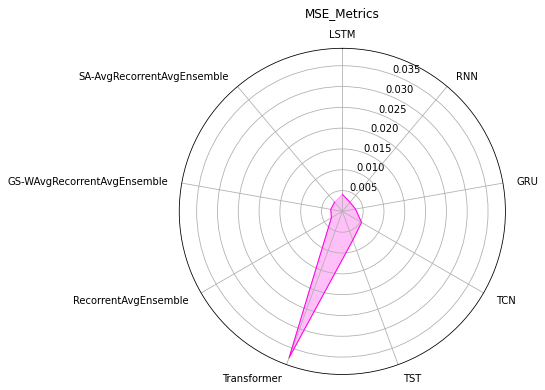

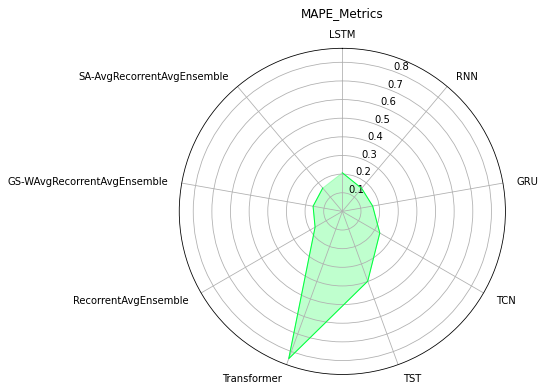

In [23]:
models_labels = calc_result_df['model'].tolist()
print(models_labels)
MSE_Values = calc_result_df['calculate_MSE'].tolist()
PolarPlotMaker(models_labels, MSE_Values, '#FF00E4', 'MSE_Metrics')

MAPE_Values = calc_result_df['calculate_MAPE'].tolist()
PolarPlotMaker(models_labels, MAPE_Values, '#00FF3E', 'MAPE_Metrics')

In [24]:
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = default_scaler.min_[-1], default_scaler.scale_[-1]

In [25]:
descaled_sa_avg_ensemble_prediction = descale(descaler, sa.best_ensemble_result)
descaled_w_avg_ensemble_prediction = descale(descaler, w_avg_prediction)
descaled_avg_ensemble_prediction = descale(descaler, ensemble_predictions)
descaled_rnn_prediction = descale(descaler, rnn_outputs)
descaled_gru_prediction = descale(descaler, gru_outputs)
descaled_lstm_prediction = descale(descaler, lstm_outputs)
descaled_label = descale(descaler, labels)

# Previsões comparadas ao SA-Ensemble

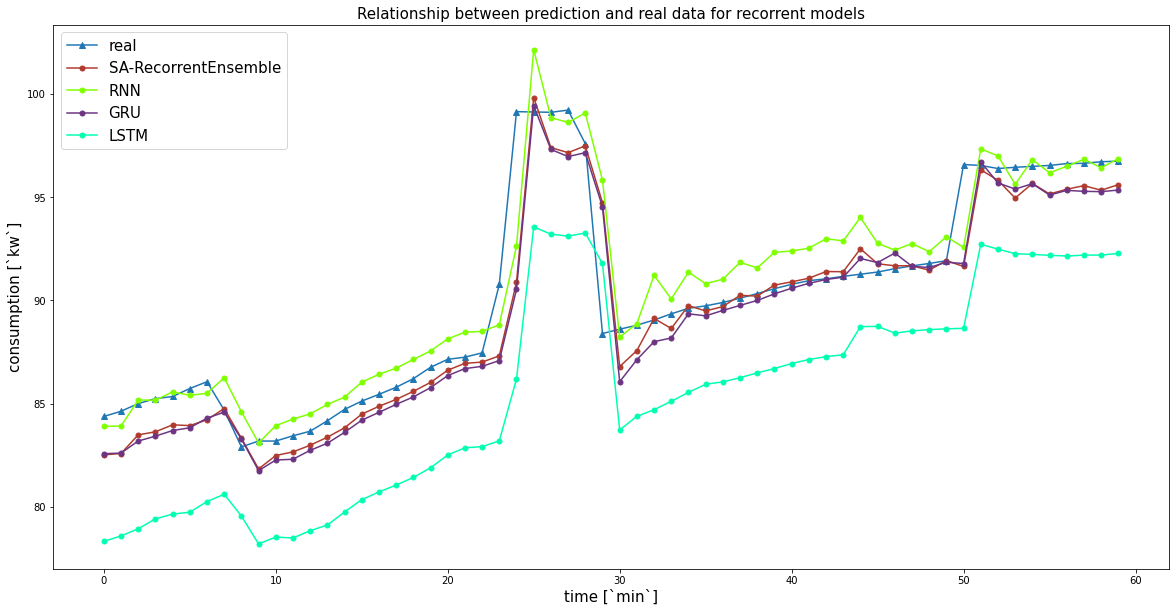

In [26]:
plt.figure(figsize=(20, 10))
plt.title(f'Relationship between prediction and real data for recorrent models', fontsize=15)
plt.plot(descaled_label[:60], '^', ls='-',label='real')
plt.plot(descaled_sa_avg_ensemble_prediction[:60], '.', ms = 10, ls = '-', c = '#B03A2E',label='SA-RecorrentEnsemble')
plt.plot(descaled_rnn_prediction[:60], '.', ms = 10, ls = '-', c = '#7FFF00',label='RNN')
plt.plot(descaled_gru_prediction[:60], '.', ms = 10, ls = '-', c = '#6C3483',label='GRU')
plt.plot(descaled_lstm_prediction[:60], '.', ms = 10, ls = '-', c = '#00FFB2',label='LSTM')



# plt.plot(output, 'm--', label='predictions')

plt.xlabel('time [`min`]', fontsize=15)
plt.ylabel('consumption [`kw`]', fontsize=15)
plt.legend(fontsize=15)
# plt.savefig(f'methodology/imgs/results/forecasting/others_models_forecasting.eps', dpi=600, bbox_inches='tight')
# plt.savefig(f'methodology/imgs/results/forecasting/others_models_forecasting.svg', dpi=600, bbox_inches='tight')
plt.show()

# Comparativos entre Ensembles

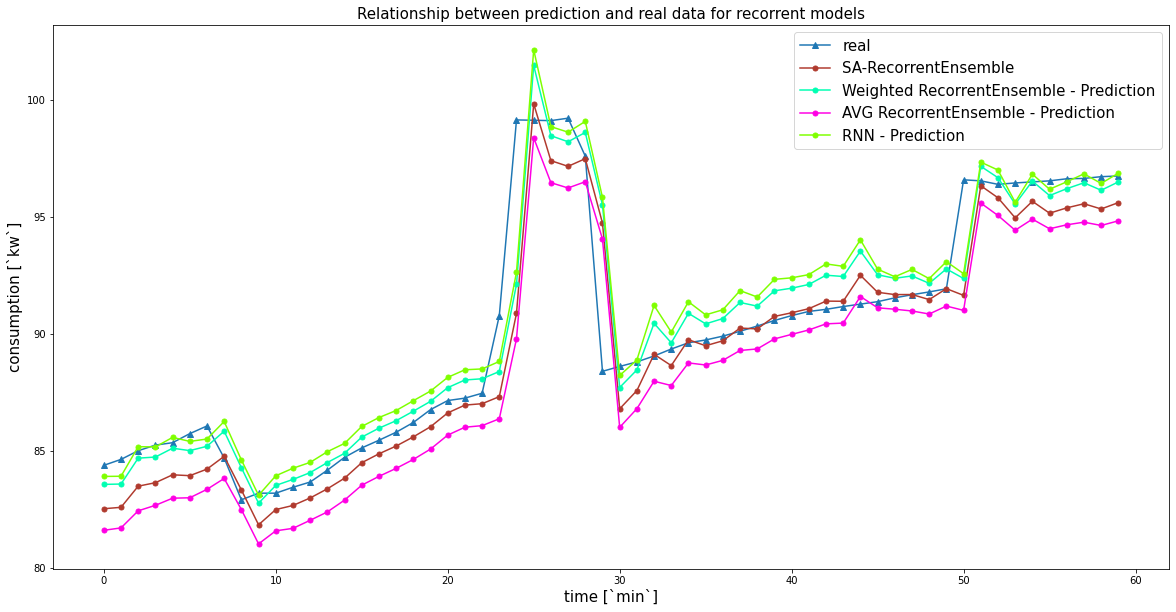

In [27]:
plt.figure(figsize=(20, 10))
plt.title(f'Relationship between prediction and real data for recorrent models', fontsize=15)
plt.plot(descaled_label[:60], '^', ls='-',label='real')
plt.plot(descaled_sa_avg_ensemble_prediction[:60], '.', ms = 10, ls = '-', c = '#B03A2E',label='SA-RecorrentEnsemble')
plt.plot(descaled_w_avg_ensemble_prediction[:60], '.', ms = 10, ls = '-', c = '#00FFB2',label='Weighted RecorrentEnsemble - Prediction')
plt.plot(descaled_avg_ensemble_prediction[:60], '.', ms = 10, ls = '-', c = '#FF00E4',label='AVG RecorrentEnsemble - Prediction')
plt.plot(descaled_rnn_prediction[:60], '.', ms = 10, ls = '-', c = '#7FFF00',label='RNN - Prediction')

# plt.plot(output, 'm--', label='predictions')

plt.xlabel('time [`min`]', fontsize=15)
plt.ylabel('consumption [`kw`]', fontsize=15)
plt.legend(fontsize=15)
# plt.savefig(f'methodology/imgs/results/forecasting/others_models_forecasting.eps', dpi=600, bbox_inches='tight')
# plt.savefig(f'methodology/imgs/results/forecasting/others_models_forecasting.svg', dpi=600, bbox_inches='tight')
plt.show()